<a href="https://colab.research.google.com/github/filipkorthals/UAVRoutePlanning/blob/edge_detection/jupyter_notebooks/edges_detection_hysteresis_thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee

ee.Authenticate()
ee.Initialize(project="uav-route-planning")
import geemap
import numpy as np

"""Class detecting edges in images using different bands from Sentinel2"""
class FieldsDetector:

    def __init__(self, start_date: str, end_date: str, latitude: float,
                 longitude: float):
        self.__start_date = start_date
        self.__end_date = end_date
        self.__point = ee.Geometry.Point([latitude, longitude])
        self.__cloud_filter_threshold = 5

    # Finding selected band in a selected place
    def get_band_image(self, band: str) -> ee.Image:
        return (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                .filterDate(self.__start_date, self.__end_date)
                .filterBounds(self.__point)
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', self.__cloud_filter_threshold))
                .select(band)
                .mean())

    # Clouds masking is used only for comparison and visualization
    # TODO: change this function
    def __mask_s2_clouds(self, image: ee.Image) -> ee.Image:
        """Masks clouds in a Sentinel-2 image using the QA band.

        Args:
            image (ee.Image): A Sentinel-2 image.

        Returns:
            ee.Image: A cloud-masked Sentinel-2 image.
        """
        qa = image.select('QA60')

        # Bits 10 and 11 are clouds and cirrus, respectively.
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11

        # Both flags should be set to zero, indicating clear conditions.
        mask = (
            qa.bitwiseAnd(cloud_bit_mask)
            .eq(0)
            .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
        )

        return image.updateMask(mask).divide(10000)

    def get_RGB_map(self) -> ee.Image:
        return (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                .filterDate(self.__start_date, self.__end_date)
                .filterBounds(self.__point)
                # Pre-filter to get less cloudy granules.
                .filter(
            ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', self.__cloud_filter_threshold)
        )
                .map(self.__mask_s2_clouds)
                .mean())

    def run_canny_for_bands(self, thresholds: list, sigmas: list,
                            bands_data: list, distance: int) -> ee.Image:
        """ Function runs Canny edge detection algorithm for every provided band """
        bands_after_canny = []
        for i in range(len(bands_data)):

            low_threshold_detection = (
                ee.Algorithms.CannyEdgeDetector(
                    image=bands_data[i], threshold=thresholds[i], sigma=sigmas[i]
                )
            ).gt(0)
            high_threshold_detection = (
                ee.Algorithms.CannyEdgeDetector(
                    image=bands_data[i], threshold=thresholds[i+1], sigma=sigmas[i]
                )
            ).gt(0)
            hysteresis_threshold = low_threshold_detection.And(high_threshold_detection.focal_max(distance, 'square', 'pixels'))
            bands_after_canny.append(high_threshold_detection.Or(hysteresis_threshold))

        if (len(bands_after_canny) > 1):
          aggregated_canny = bands_after_canny[0].add(bands_after_canny[1])
          for i in range (2, len(bands_after_canny)):
              aggregated_canny = aggregated_canny.add(bands_after_canny[i])
          return aggregated_canny.select(aggregated_canny.bandNames().get(0).getInfo())
        return bands_after_canny[0]

    def return_results_on_map(self, results: ee.Image, scale: int,
                            results_description: str) -> geemap.Map:
        resultMap = geemap.Map()
        resultMap.set_center(self.__point.coordinates().getInfo()[0], self.__point.coordinates().getInfo()[1], scale)
        visualization = {
            'min': 0.0,
            'max': 0.3,
            'bands': ['B4', 'B3', 'B2'],
        }
        resultMap.addLayer(self.get_RGB_map(), visualization, "Source map")
        resultMap.addLayer(results.updateMask(results), {"palette": ["ffffff"]}, results_description)
        return resultMap

    def run_fields_detection(self, bands: list, thresholds: list, sigmas: list,
                             distance: int, scale: int, results_description: str) -> geemap.Map:
        bands_data = []
        for band in bands:
            bands_data.append(self.get_band_image(band))
        aggregated_canny = self.run_canny_for_bands(thresholds, sigmas, bands_data, distance)
        return self.return_results_on_map(aggregated_canny, scale, results_description)

    def get_fields_detection_as_numpy(self, bands: list, thresholds: list, sigma: int,
                             distance: int, scale: int):
        bands_data = []
        for band in bands:
            bands_data.append(self.get_band_image(band))
        aggregated_canny = self.run_canny_for_bands(thresholds, sigma, bands_data, distance)

        patch_size = 256
        img_resolution = 10

        proj = ee.Projection('EPSG:32632')
        poi_reproj = self.__point.transform(proj, 1)
        poi_re_buffer = poi_reproj.buffer((patch_size/2)*img_resolution)

        # Reproject image and keeping the same image resolution of 10 m
        img = aggregated_canny.reproject(proj, None, 10)

        # Extract Rectangle from Image
        band_arrs = img.sampleRectangle(region=poi_re_buffer, defaultValue=0)

        # Rectangle values to numpy array
        new_image = None
        for band in img.bandNames().getInfo():
            current_band = band_arrs.get(band)
            img = np.array(current_band.getInfo())
            img = img.astype(float)
            # Stacking each band
            if new_image is None:
                new_image = img
            else:
                new_image = np.dstack([new_image,img])
        return new_image


In [ ]:
""" detection for RGB +  NIR - for fields"""
""" TO JEST DOBRE - tymczasowo wyrzucony NIR - B8"""

longitude = 54.6014 # y
latitude = 18.090 # x
start_date = '2024-05-01'
end_date = '2024-09-01'

detector = FieldsDetector(start_date, end_date, latitude, longitude)
map = detector.run_fields_detection(['B4', 'B3', 'B2'], [120 if i % 2 == 0 else 90 for i in range(6)], [5, 9, 1.5], 5, 16, "Canny dla RGB + NIR")
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
""" tylko B4 """

longitude = 54.6014 # y
latitude = 18.090 # x
start_date = '2024-05-01'
end_date = '2024-08-30'

detector = FieldsDetector('2024-05-01', '2024-08-30', latitude, longitude)
map = detector.run_fields_detection(['B4'], [120 if i % 2 == 0 else 90 for i in range(2)], [2.4], 5, 16, "Canny")
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
""" tylko B3 """

longitude = 54.6014 # y
latitude = 18.090 # x
start_date = '2024-05-01'
end_date = '2024-08-30'

detector = FieldsDetector('2024-05-01', '2024-08-30', latitude, longitude)
map = detector.run_fields_detection(['B3'], [120 if i % 2 == 0 else 90 for i in range(2)], [5], 5, 16, "Canny")
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
""" tylko B2 """

longitude = 54.6014 # y
latitude = 18.090 # x
start_date = '2024-05-01'
end_date = '2024-08-30'

detector = FieldsDetector('2024-05-01', '2024-08-30', latitude, longitude)
map = detector.run_fields_detection(['B2'], [120 if i % 2 == 0 else 90 for i in range(2)], [1], 5, 16, "Canny")
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
""" tylko B8 """

longitude = 54.6014 # y
latitude = 18.090 # x
start_date = '2024-05-01'
end_date = '2024-08-30'

detector = FieldsDetector('2024-05-01', '2024-08-30', latitude, longitude)
map = detector.run_fields_detection(['B8'], [120 if i % 2 == 0 else 60 for i in range(2)], [15], 5, 16, "Canny")
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
""" tylko B12 """

longitude = 54.6014 # y
latitude = 18.090 # x
start_date = '2024-05-01'
end_date = '2024-08-30'

detector = FieldsDetector('2024-05-01', '2024-08-30', latitude, longitude)
map = detector.run_fields_detection(['B12'], [120 if i % 2 == 0 else 90 for i in range(2)], [5], 5, 16, "Canny")
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
""" tylko B8A """

longitude = 54.6014 # y
latitude = 18.090 # x
start_date = '2024-05-01'
end_date = '2024-08-30'

detector = FieldsDetector('2024-05-01', '2024-08-30', latitude, longitude)
map = detector.run_fields_detection(['B8A'], [120 if i % 2 == 0 else 90 for i in range(2)], [5], 5, 16, "Canny")
map

Map(center=[54.6014, 18.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

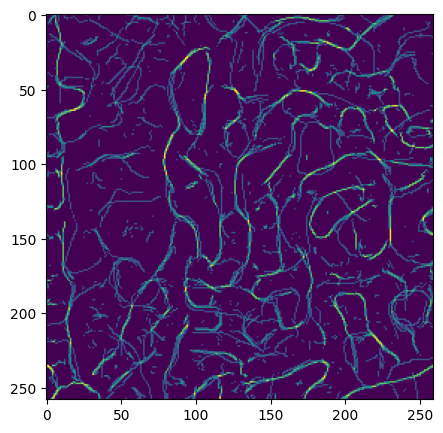

In [ ]:
""" NUMPY VISUALISATION detection for RGB +  NIR"""

longitude = 54.6014 # y
latitude = 18.090 # x
start_date = '2024-05-01'
end_date = '2024-08-30'

detector = FieldsDetector('2024-05-01', '2024-08-30', latitude, longitude)
img_array = detector.get_fields_detection_as_numpy(['B4', 'B3', 'B2', 'B8'], [5, 30, 5, 30, 5, 30, 5, 30], [7 for i in range(8)], 10, 16)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot Image in an RGB Composite
axs.imshow(img_array)
plt.show()